# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [14]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12 # 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [15]:
# Load train and test splits.
def preprocess(x):
    image = tf.image.convert_image_dtype(x['image'], tf.float32)
    subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
    return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

# Model creation

In [16]:
#@test {"output": "ignore"}

# Build CNN teacher.
import tensorflow.compat.v2.keras.layers as layers


def initialize_cnn():
  cnn_model = tf.keras.Sequential()

  # your code start from here for stpe 2
  cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
  cnn_model.add(layers.MaxPooling2D((2, 2), strides=(1, 1)))
  cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  cnn_model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
  cnn_model.add(layers.Flatten())
  cnn_model.add(layers.Dropout(0.5))
  cnn_model.add(layers.Dense(128, activation='relu'))
  cnn_model.add(layers.Dropout(0.5))
  cnn_model.add(layers.Dense(10))
  return cnn_model



def initialize_fc():
  # Build fully connected student.
  fc_model = tf.keras.Sequential()
  fc_model.add(layers.Flatten())
  fc_model.add(layers.Dense(784, activation='relu'))
  fc_model.add(layers.Dense(784, activation='relu'))
  fc_model.add(layers.Dense(10))
  return fc_model

cnn_model = initialize_cnn()
fc_model = initialize_fc()


# Teacher loss function

In [17]:
@tf.function
def compute_teacher_loss(images, labels):
    """Compute subclass knowledge distillation teacher loss for given images
     and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    subclass_logits = cnn_model(images, training=True)

    # your code start from here for step 3

    cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits)

    return tf.reduce_mean(cross_entropy_loss_value)

# Student loss function

In [18]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
    """Compute distillation loss.

    This function computes cross entropy between softened logits and softened
    targets. The resulting loss is scaled by the squared temperature so that
    the gradient magnitude remains approximately constant as the temperature is
    changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
    a neural network."

    Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

    Returns:
    A scalar Tensor containing the distillation loss.
    """
    # your code start from here for step 3
    soft_targets = tf.nn.softmax(teacher_logits / temperature)
    '''
    kl = tf.keras.losses.KLDivergence()


    return tf.reduce_mean(kl(soft_targets, student_logits / temperature)) * temperature ** 2
    '''
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
    """Compute subclass knowledge distillation student loss for given images
     and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    student_subclass_logits = fc_model(images, training=True)

    # Compute subclass distillation loss between student subclass logits and
    # softened teacher subclass targets probabilities.

    # your code start from here for step 3

    teacher_subclass_logits = cnn_model(images, training=False)

    student_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits)
    student_loss_value = tf.reduce_mean(student_loss_value)

    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)
    # Compute cross-entropy loss with hard targets.

    # your code start from here for step 3
    student_loss = distillation_loss_value * ALPHA + student_loss_value * (1 - ALPHA)
    #print(distillation_loss_value.numpy())

    return student_loss

# Train and evaluation

In [19]:
@tf.function
def compute_num_correct(model, images, labels):
    """Compute number of correctly classified images in a batch.

    Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Number of correctly classified images.
    """
    class_logits = model(images, training=False)
    return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32))


def train_and_evaluate(model, compute_loss_fn, compute_num_correct):
    """Perform training and evaluation for a given model.

    Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
    """

    # your code start from here for step 4
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    for epoch in range(1, NUM_EPOCHS + 1):
        # Run training.
        print('Epoch {}: '.format(epoch), end='')
        for images, labels in mnist_train:
            with tf.GradientTape() as tape:
                # your code start from here for step 4
                loss_value = compute_loss_fn(images, labels)
                #print("loss value " + str(loss_value.numpy()))

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Run evaluation.
        num_correct = 0
        num_total = builder.info.splits['test'].num_examples
    
        for images, labels in mnist_test:
            # your code start from here for step 4
            num_correct += compute_num_correct(model, images, labels)

        print("Class_accuracy: " + '{:.2f}%'.format(
            num_correct / num_total * 100))


# Training models

In [20]:
# your code start from here for step 5 
print("------Teacher-------")
train_and_evaluate(cnn_model, compute_teacher_loss, compute_num_correct)


------Teacher-------
Epoch 1: Class_accuracy: 98.27%
Epoch 2: Class_accuracy: 98.55%
Epoch 3: Class_accuracy: 98.85%
Epoch 4: Class_accuracy: 99.01%
Epoch 5: Class_accuracy: 98.94%
Epoch 6: Class_accuracy: 99.03%
Epoch 7: Class_accuracy: 98.88%
Epoch 8: Class_accuracy: 99.15%
Epoch 9: Class_accuracy: 99.20%
Epoch 10: Class_accuracy: 99.14%
Epoch 11: Class_accuracy: 99.19%
Epoch 12: Class_accuracy: 99.29%


In [21]:
print("------Student-------")
train_and_evaluate(fc_model, compute_student_loss, compute_num_correct)

------Student-------
Epoch 1: Class_accuracy: 96.70%
Epoch 2: Class_accuracy: 97.86%
Epoch 3: Class_accuracy: 98.22%
Epoch 4: Class_accuracy: 98.37%
Epoch 5: Class_accuracy: 98.54%
Epoch 6: Class_accuracy: 98.54%
Epoch 7: Class_accuracy: 98.75%
Epoch 8: Class_accuracy: 98.65%
Epoch 9: Class_accuracy: 98.76%
Epoch 10: Class_accuracy: 98.72%
Epoch 11: Class_accuracy: 98.70%
Epoch 12: Class_accuracy: 98.85%


# Test accuracy vs. tempreture curve

Temperature = 1
Class_accuracy: 98.25%
Class_accuracy: 98.59%
Class_accuracy: 98.45%
Class_accuracy: 98.59%
Class_accuracy: 98.60%
Class_accuracy: 98.21%
Class_accuracy: 98.52%
Class_accuracy: 98.53%
Class_accuracy: 98.32%
Class_accuracy: 98.51%
Class_accuracy: 98.80%
Class_accuracy: 98.80%
Temperature = 2
Class_accuracy: 98.77%
Class_accuracy: 98.74%
Class_accuracy: 98.78%
Class_accuracy: 98.74%
Class_accuracy: 98.78%
Class_accuracy: 98.67%
Class_accuracy: 98.77%
Class_accuracy: 98.81%
Class_accuracy: 98.85%
Class_accuracy: 98.71%
Class_accuracy: 98.84%
Class_accuracy: 98.79%
Temperature = 4
Class_accuracy: 98.78%
Class_accuracy: 98.87%
Class_accuracy: 98.94%
Class_accuracy: 98.84%
Class_accuracy: 98.89%
Class_accuracy: 98.96%
Class_accuracy: 98.99%
Class_accuracy: 98.89%
Class_accuracy: 98.92%
Class_accuracy: 98.90%
Class_accuracy: 98.86%
Class_accuracy: 98.97%
Temperature = 16
Class_accuracy: 98.89%
Class_accuracy: 98.96%
Class_accuracy: 99.01%
Class_accuracy: 98.98%
Class_accuracy:

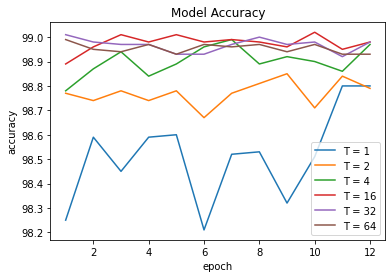

In [22]:
# your code start from here for step 6
#6. Plot a curve representing student test accuracy vs. temperature hyperparameters (T = 1,2,4,16,32, and 64) 
#when the task balance parameter is 0.5. 
#Explain the effect of temperature hyperparameter in this experiment. [1 Marks]

def compute_student_loss_plot(images, labels, temperature, alpha=0.5):
  student_class_logits = fc_model(images, training=True)
  teacher_class_logits = cnn_model(images, training=False)
  
  distillation_loss_value = distillation_loss(teacher_class_logits, student_class_logits, temperature)
  
  student_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))
  cross_entropy_loss_value = alpha * student_loss + (1 - alpha) * distillation_loss_value
  return cross_entropy_loss_value

def train_and_evaluate_plot(model, compute_loss_fn, temperature, alpha=0.5):
  """Perform training and evaluation for a given model.

  Args:
  model: Instance of tf.keras.Model.
  compute_loss_fn: A function that computes the training loss given the
  images, and labels.
  """
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  test_accuracy = []

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels, temperature, alpha=0.5)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)
    print("Class_accuracy: " + '{:.2f}%'.format(
         num_correct / num_total * 100))
    test_accuracy.append(num_correct / num_total * 100)
  return test_accuracy

# your code start from here for step 6
import matplotlib.pyplot as plt

T = [1,2,4,16,32,64]
TEST_ACCUR = []
epoch = [i for i in range(1, NUM_EPOCHS + 1)]

for t in T:
  print(f'Temperature = {t}')
  test_accuracy = train_and_evaluate_plot(fc_model,compute_student_loss_plot, t)
  temp = str(t)
  temp,  = plt.plot(epoch, test_accuracy, label=f'T = {t}')
  TEST_ACCUR.append(temp)

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(handles=TEST_ACCUR)
plt.show()


# Train student from scratch

In [23]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(layers.Flatten())
fc_model_no_distillation.add(layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(layers.Dense(10))



#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits)
  
  return cross_entropy_loss

#Best to include an average 
train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss, compute_num_correct)

Epoch 1: Class_accuracy: 95.99%
Epoch 2: Class_accuracy: 97.47%
Epoch 3: Class_accuracy: 97.93%
Epoch 4: Class_accuracy: 97.89%
Epoch 5: Class_accuracy: 97.91%
Epoch 6: Class_accuracy: 97.80%
Epoch 7: Class_accuracy: 98.33%
Epoch 8: Class_accuracy: 97.98%
Epoch 9: Class_accuracy: 98.09%
Epoch 10: Class_accuracy: 98.19%
Epoch 11: Class_accuracy: 97.87%
Epoch 12: Class_accuracy: 98.11%


# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [24]:
!pip install keras-flops
# your code start from here for step 8
from keras_flops import get_flops
# use get_flops

#Teacher: 
teacher_flops = get_flops(cnn_model, batch_size=1)
print(f"Teacher_flops: {teacher_flops / 10 ** 9:.03} G")
#Student: 
student_flops = get_flops(fc_model, batch_size=1)
print(f"Student_flops: {student_flops / 10 ** 9:.03} G")

student_no_dist_flops = get_flops(fc_model_no_distillation, batch_size=1)
print(f"Student_no_dist_flops: {student_no_dist_flops / 10 ** 9:.03} G")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Teacher_flops: 0.022 G
Student_flops: 0.00248 G
Student_no_dist_flops: 0.00248 G


# Implementing the state-of-the-art KD algorithm

In [25]:
import numpy as np

# your code start from here for step 12
class CNN_SubClass:
  def __init__(self, num_of_subclass, temperature, beta):
    self.num_of_subclass = num_of_subclass
    self.temperature = temperature
    self.beta = beta
    self.model = tf.keras.Sequential()

    # your code start from here for stpe 2
    self.model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    self.model.add(layers.MaxPooling2D((2, 2), strides=(1, 1)))
    self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    self.model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    self.model.add(layers.Flatten())
    self.model.add(layers.Dropout(0.5))
    self.model.add(layers.Dense(128, activation='relu'))
    self.model.add(layers.Dropout(0.5))
    self.model.add(layers.Dense(10*num_of_subclass))
  
  def loss_function(self, images, labels):

    subclass_logits = self.model(images, training=True)
    # tf.shape(subclass_logits)[0] is batch size 
    # sum all subclass of a class, get back size 256 x 10 logits 
    class_logits = tf.reduce_sum(tf.reshape(subclass_logits, (tf.shape(subclass_logits)[0], 10, self.num_of_subclass)),axis=2)
    cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=class_logits))


    mean = tf.math.reduce_mean(subclass_logits, axis=1)
    var = tf.math.reduce_variance(subclass_logits, axis=1)


    
    normalize = tf.keras.layers.Normalization(axis=0, mean=mean, variance=var)
    normalized_logits = normalize(subclass_logits)
  
    # dot product to get to 256 by 256 size 
    # input 256 * 20, so M dot M.T
    
    # summing all rows to get exponential sum 
    exp_sum = tf.reduce_sum(
        #dot product of normalized logit with it self
        tf.math.exp(tf.matmul(
            normalized_logits, 
            tf.transpose(normalized_logits)) / self.temperature),
            axis=1)
  
    
    log_avg = tf.reduce_mean(tf.math.log(exp_sum))
    # n = batch size 
    aux_loss = log_avg - 1 / self.temperature - np.log(tf.shape(subclass_logits)[0])
    #print(aux_loss)

    total_loss = cross_entropy_loss_value  + self.beta * aux_loss

    #print(total_loss)

    return total_loss 
  
  def compute_num_correct(self, model, images, labels):
    subclass_logits = model(images, training=False)
    # tf.shape(subclass_logits)[0] is batch size 
    class_logits = tf.reduce_sum(tf.reshape(subclass_logits, (tf.shape(subclass_logits)[0], 10, self.num_of_subclass)),axis=2)
    
    return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32))
  







In [26]:
class FC_SubClass:
  def __init__(self, num_of_subclass, temperature, alpha):
    self.num_of_subclass = num_of_subclass
    self.temperature = temperature
    self.alpha = alpha
    self.model = tf.keras.Sequential()

    # your code start from here for stpe 2
    self.model = tf.keras.Sequential()
    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(784, activation='relu'))
    self.model.add(layers.Dense(784, activation='relu'))
    self.model.add(layers.Dense(10*num_of_subclass))

  def compute_num_correct(self, model, images, labels):
    subclass_logits = model(images, training=False)
    # tf.shape(subclass_logits)[0] is batch size 
    class_logits = tf.reduce_sum(tf.reshape(subclass_logits, (tf.shape(subclass_logits)[0], 10, self.num_of_subclass)),axis=2)
    
    return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32))
    

  def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
    
    soft_targets = tf.nn.softmax(teacher_logits / temperature)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(soft_targets, student_logits / temperature)) * temperature ** 2
    
  def loss_function(self, images, labels, teacher_model):

    student_subclass_logits = self.model(images, training=True)

    class_logits = tf.reduce_sum(tf.reshape(student_subclass_logits, (tf.shape(student_subclass_logits)[0], 10, self.num_of_subclass)),axis=2)

    # Compute subclass distillation loss between student subclass logits and
    # softened teacher subclass targets probabilities.

    # your code start from here for step 3

    teacher_subclass_logits = teacher_model(images, training=False)

    student_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=class_logits)
    student_loss_value = tf.reduce_mean(student_loss_value)

    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)
    # Compute cross-entropy loss with hard targets.

    # your code start from here for step 3
    student_loss = distillation_loss_value * ALPHA + student_loss_value * (1 - ALPHA)

    return student_loss 
  
  



In [27]:
def train_and_evaluate_student(model, teacher_model, compute_loss_fn, compute_num_correct):
    """Perform training and evaluation for a given model.

    Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
    """

    # your code start from here for step 4
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    for epoch in range(1, NUM_EPOCHS + 1):
        # Run training.
        print('Epoch {}: '.format(epoch), end='')
        for images, labels in mnist_train:
            with tf.GradientTape() as tape:
                # your code start from here for step 4
                loss_value = compute_loss_fn(images, labels, teacher_model)
                #print("loss value " + str(loss_value.numpy()))

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Run evaluation.
        num_correct = 0
        num_total = builder.info.splits['test'].num_examples
    
        for images, labels in mnist_test:
            # your code start from here for step 4
            num_correct += compute_num_correct(model, images, labels)

        print("Class_accuracy: " + '{:.2f}%'.format(
            num_correct / num_total * 100))

In [28]:
updated_cnn = CNN_SubClass(2, 20, 0.3)
train_and_evaluate(updated_cnn.model, updated_cnn.loss_function, updated_cnn.compute_num_correct)


Epoch 1: Class_accuracy: 98.12%
Epoch 2: Class_accuracy: 98.79%
Epoch 3: Class_accuracy: 98.89%
Epoch 4: Class_accuracy: 99.07%
Epoch 5: Class_accuracy: 99.01%
Epoch 6: Class_accuracy: 99.16%
Epoch 7: Class_accuracy: 99.22%
Epoch 8: Class_accuracy: 99.17%
Epoch 9: Class_accuracy: 99.27%
Epoch 10: Class_accuracy: 99.20%
Epoch 11: Class_accuracy: 99.20%
Epoch 12: Class_accuracy: 99.25%


In [29]:
updated_fc = FC_SubClass(2, 4, 0.5)
train_and_evaluate_student(updated_fc.model, updated_cnn.model, updated_fc.loss_function, updated_fc.compute_num_correct)

Epoch 1: Class_accuracy: 97.57%
Epoch 2: Class_accuracy: 98.23%
Epoch 3: Class_accuracy: 98.48%
Epoch 4: Class_accuracy: 98.57%
Epoch 5: Class_accuracy: 98.69%
Epoch 6: Class_accuracy: 98.76%
Epoch 7: Class_accuracy: 98.76%
Epoch 8: Class_accuracy: 98.79%
Epoch 9: Class_accuracy: 98.81%
Epoch 10: Class_accuracy: 98.82%
Epoch 11: Class_accuracy: 98.85%
Epoch 12: Class_accuracy: 98.82%


# (Optional) XAI method to explain models

In [30]:
# your code start from here for step 13
import numpy as np
#Test loss function 

x = tf.random.uniform(shape=[500, 80], dtype=tf.float32)
y = tf.reduce_sum(
    tf.reshape(x, (500, 40, 2)),
    axis=2
)
#print(y)
mean = tf.math.reduce_mean(y, axis=1)
#print(mean)
var = tf.math.reduce_variance(y, axis=1)
#print(var)
layer = tf.keras.layers.Normalization(axis= 0, mean=mean, variance=var)
z = layer(y)

T = 10

exp_sum = tf.reduce_sum(
    tf.math.exp(tf.tensordot(z, tf.transpose(z), 1) / T),
    axis=1)

log_avg = tf.reduce_mean(tf.math.log(exp_sum))
# n = batch size 
aux_loss = log_avg - 1/T - np.log(500)
print(aux_loss)


tf.Tensor(0.1902628, shape=(), dtype=float32)


In [31]:
import numpy as np
a = [[  0.21940991, 1.821567], [-0.03301997,  1.5130547]]

b = [[  0.21940991, 1.821567], [-0.03301997,  1.5130547]]



c = np.dot(a,np.transpose(b))

a_t = tf.constant(a)
b_t = tf.constant(b)

print(c)
print(tf.tensordot(a_t, tf.transpose(b_t),1))



[[3.36624704 2.7488856 ]
 [2.7488856  2.29042484]]
tf.Tensor(
[[3.3662474 2.7488859]
 [2.7488859 2.2904248]], shape=(2, 2), dtype=float32)
